In [1]:
# import misc libraries
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random
import numpy as np

# import torch modules
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms as T
from torchinfo import summary

print('torch:', torch.__version__)
print("torchvision:", torchvision.__version__)

# import captum modules
import captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

print('captum:', captum.__version__)

# preset variables
classes = ['NORMAL', 'PNEUMONIA']

def seed_everything(seed=42):
    """
    > It sets the seed for the random number generator in Python, NumPy, and PyTorch
    
    :param seed: the random seed to use for the random number generator, defaults to 42 (optional)
    :return: The seed value
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # for pytorch
    return seed

seed = seed_everything(seed=0)

torch: 1.12.0+cpu
torchvision: 0.13.0+cpu
captum: 0.5.0


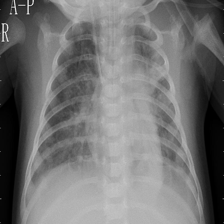

In [2]:
# load image
def get_image(path:str)->Image.Image:
    return Image.open(path).convert('RGB').resize((224, 224))

img = get_image('../assets/image/PNEUMONIA/person1946_bacteria_4874.jpeg')
img

In [3]:
# image preprocessing
transform = T.Compose([
    T.Resize(224),
    T.ToTensor()
])

norm_cfg = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
transform_normalize = T.Normalize(**norm_cfg)


transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
input.shape

torch.Size([1, 3, 224, 224])

In [4]:
def load_model(type='mobilenetv3', path='../assets/weights/mobilenetv3_ver2_best_weights.pth'):
    assert os.path.exists(path), 'path does not exists'
    if type == 'mobilenetv3':
        model = models.mobilenet_v3_large()
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, 2)
        model.load_state_dict(torch.load(path))
        return model

model = load_model()

In [5]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print("prediction score:", prediction_score)
print("predicted label:", pred_label_idx, classes[pred_label_idx])

prediction score: tensor([[0.9985]], grad_fn=<TopkBackward0>)
predicted label: tensor([[1]]) PNEUMONIA


In [6]:
## define attribution methods
integrated_gradients = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(integrated_gradients)



In [7]:
%%time
# create attribution
attributions_ig_nt = noise_tunnel.attribute(
    input, 
    nt_samples=1, 
    nt_type='smoothgrad_sq', 
    target=pred_label_idx
)

Wall time: 12.7 s


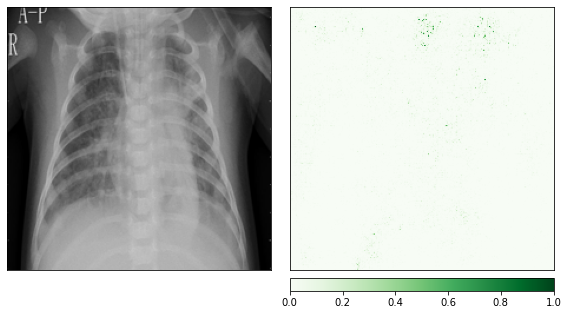

In [8]:
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    # cmap=default_cmap,
    show_colorbar=True
)